# Data Analysis

In [1]:
import openml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from project.model import MultilayerPerceptron 


dataset_id = 45069

dataset = openml.datasets.get_dataset(dataset_id)
X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)


if y is not None:
    df = pd.concat([X, y], axis=1)
else:
    df = X

print(df.head())


   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  1                         3                    7   
1                  5                         1                    1   
2                  2                         1                    1   
3                  3                         1                    1   
4                  3                         1                    1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                 4                  41               2               17   
1                 3                  64               0               10   
2                 2                  39               0                8   
3                 1                  39               2               12   
4                 3                  21               2               23   

   number_outpatient  number_emergency  number_inpatient  ...  citoglipton  \
0                  0                 0

First we load the dataset from OpenML (if we run this for the first time we also download OpenML with pip).

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   admission_type_id         101766 non-null  uint8   
 1   discharge_disposition_id  101766 non-null  uint8   
 2   admission_source_id       101766 non-null  uint8   
 3   time_in_hospital          101766 non-null  uint8   
 4   num_lab_procedures        101766 non-null  uint8   
 5   num_procedures            101766 non-null  uint8   
 6   num_medications           101766 non-null  uint8   
 7   number_outpatient         101766 non-null  uint8   
 8   number_emergency          101766 non-null  uint8   
 9   number_inpatient          101766 non-null  uint8   
 10  number_diagnoses          101766 non-null  uint8   
 11  race                      99493 non-null   category
 12  gender                    101766 non-null  category
 13  age                       101

We can see that we have 101 766 records with 48 features, 36 being categorical, 1 being object and 11 being integer.

In [3]:
df.nunique()

admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          118
num_procedures                7
num_medications              75
number_outpatient            39
number_emergency             33
number_inpatient             21
number_diagnoses             16
race                          5
gender                        3
age                          10
weight                        9
payer_code                   17
medical_specialty            72
diag_1                      716
diag_2                      748
diag_3                      789
max_glu_serum                 4
A1Cresult                     4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
acetohexamide                 2
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglita

We can see that examine and citoglipton have only 1 unique value, therefore we can drop them. We will also drop weight feature since it is filled in only 3197 times (which is about 3.14%).

In [4]:
columns_to_drop = ['examide', 'citoglipton', 'weight']

df = df.drop(columns=columns_to_drop)

print(f"Columns {columns_to_drop} have been dropped.")
print("\nDataFrame columns after dropping:")
print(df.columns)

Columns ['examide', 'citoglipton', 'weight'] have been dropped.

DataFrame columns after dropping:
Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race', 'gender', 'age',
       'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'class'],
      dtype='object')


Next we will make features that represent ids into categorical features.

In [5]:
columns_to_convert_to_category = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'class']

for col in columns_to_convert_to_category:
    df[col] = df[col].astype('category')

print("Converted columns to category:")
print(df[columns_to_convert_to_category].dtypes)

Converted columns to category:
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
class                       category
dtype: object


In [6]:
categorical_cols = df.select_dtypes(include='category').columns

print("Unique values for categorical features:")

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].unique())

Unique values for categorical features:

Column: admission_type_id
[1, 5, 2, 3, 6, 8, 4, 7]
Categories (8, uint8): [1, 2, 3, 4, 5, 6, 7, 8]

Column: discharge_disposition_id
[3, 1, 6, 22, 18, ..., 10, 17, 27, 19, 20]
Length: 26
Categories (26, uint8): [1, 2, 3, 4, ..., 24, 25, 27, 28]

Column: admission_source_id
[7, 1, 17, 6, 4, ..., 8, 22, 11, 25, 13]
Length: 17
Categories (17, uint8): [1, 2, 3, 4, ..., 17, 20, 22, 25]

Column: race
['AfricanAmerican', 'Caucasian', 'Hispanic', 'Other', NaN, 'Asian']
Categories (5, object): ['AfricanAmerican' < 'Asian' < 'Caucasian' < 'Hispanic' < 'Other']

Column: gender
['Female', 'Male', 'Unknown/Invalid']
Categories (3, object): ['Female' < 'Male' < 'Unknown/Invalid']

Column: age
['[60-70)', '[50-60)', '[80-90)', '[40-50)', '[70-80)', '[90-100)', '[10-20)', '[30-40)', '[20-30)', '[0-10)']
Categories (10, object): ['[0-10)' < '[10-20)' < '[20-30)' < '[30-40)' ... '[60-70)' < '[70-80)' < '[80-90)' < '[90-100)']

Column: payer_code
['MC', 'MD', NaN,

Next we look at descriptive statistics of integer columns.

In [7]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


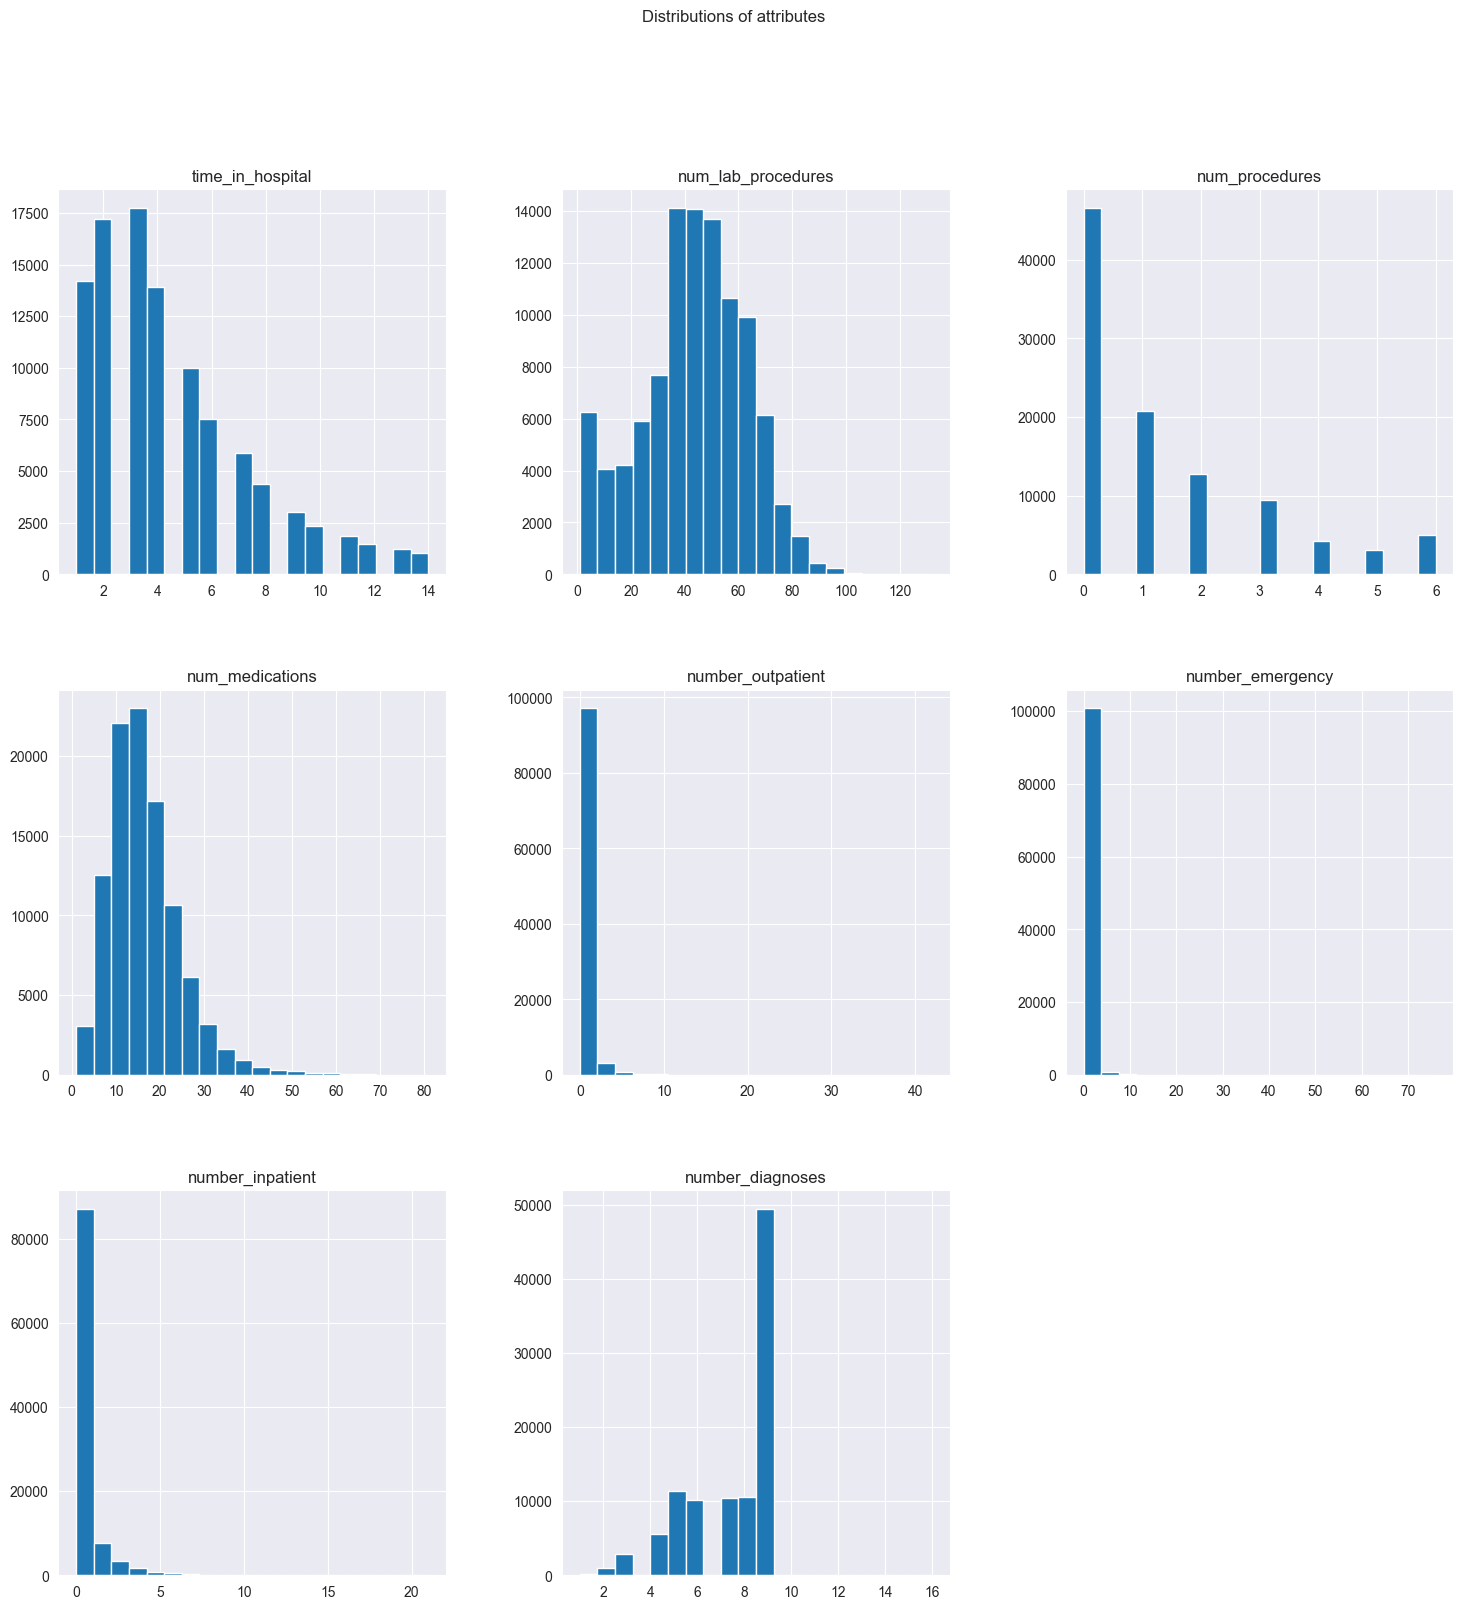

In [8]:
df.hist(figsize=(18, 18), bins=20)
plt.suptitle("Distributions of attributes")
plt.show()

Next we drop duplicates.

In [9]:
print("Shape before removing duplicates:", df.shape)

df.drop_duplicates(inplace=True)

print("Shape after removing duplicates:", df.shape)

Shape before removing duplicates: (101766, 45)
Shape after removing duplicates: (101766, 45)


We have no duplicates.

In [10]:
print(df.isnull().sum())

admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
number_diagnoses                0
race                         2273
gender                          0
age                             0
payer_code                  40256
medical_specialty           49949
diag_1                         21
diag_2                        358
diag_3                       1423
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

We have null values in race, payer_code, medical_specialty, diag_1, diag_2, diag_3 columns, we will add missing code for race, payer_code, medical_specialty, for diagnoses we will make columns for each possible diagnosis value and mark it as 1 if its pressent in either of diag_1, diag_2 or diag_3, since it doesnt matter if the diagnosis is in diag_1 or diag_3.

In [11]:
categorical_cols_with_missing = ['payer_code', 'medical_specialty']


for col in categorical_cols_with_missing:
    if col in df.columns:
        if pd.api.types.is_categorical_dtype(df[col].dtype):
            if 'Missing' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('Missing')
        df[col].fillna('Missing', inplace=True)

print("Missing values:")
display(df[categorical_cols_with_missing].isnull().sum())

Missing values:


C:\Users\maria\AppData\Local\Temp\ipykernel_32668\2350912529.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col].dtype):
C:\Users\maria\AppData\Local\Temp\ipykernel_32668\2350912529.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Missing', inplace=True)


payer_code           0
medical_specialty    0
dtype: int64

In [12]:
all_diag_codes = pd.concat([df['diag_1'], df['diag_2'], df['diag_3']]).unique()

all_diag_codes = [code for code in all_diag_codes if pd.notna(code)]

print(f"Number of unique diagnosis: {len(all_diag_codes)}")

print(all_diag_codes[:10])

Number of unique diagnosis: 915
['820', '276', '493', '250.4', '218', '250.6', '410', '486', '584', '428']


In [13]:

diag_cols_dict = {
    f'diag|{code}': ((df['diag_1'] == code) |
                      (df['diag_2'] == code) |
                      (df['diag_3'] == code)).astype(int)
    for code in all_diag_codes
}

diag_cols_df = pd.DataFrame(diag_cols_dict, index=df.index)

df = df.drop(columns=['diag_1', 'diag_2', 'diag_3'])

df = pd.concat([df, diag_cols_df], axis=1)

print("New DataFrame:")
display(df.head())


New DataFrame:


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag|744,diag|V22,diag|265,diag|E912,diag|E922,diag|E861,diag|E865,diag|387,diag|E966,diag|E864
0,1,3,7,4,41,2,17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,1,1,3,64,0,10,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,2,39,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,39,2,12,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3,1,1,3,21,2,23,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Boxplots of selected numerical columns (excluding IDs):


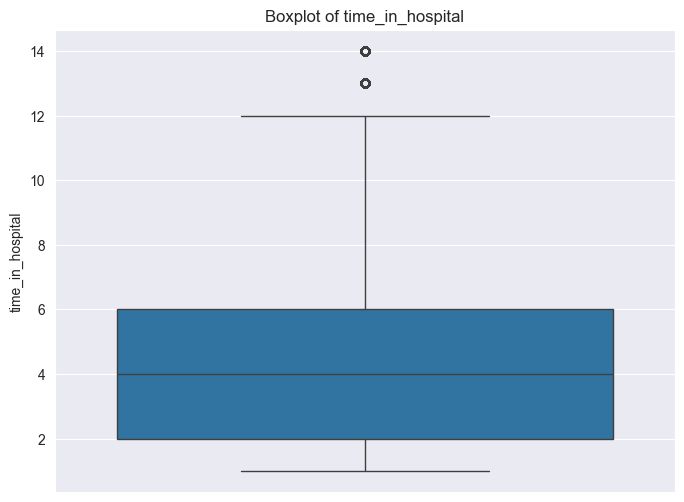

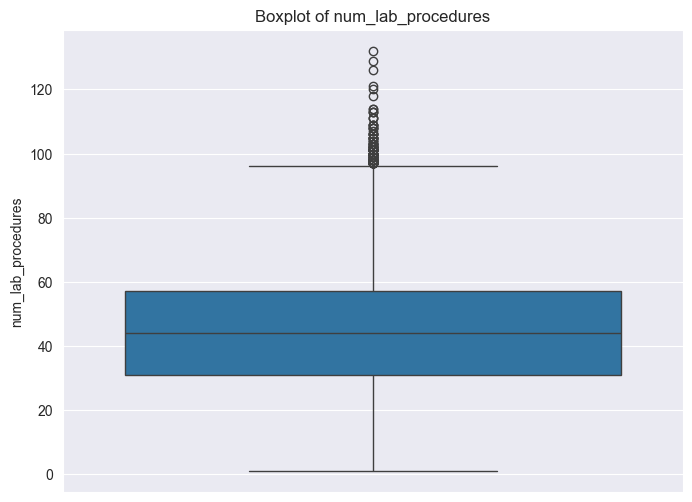

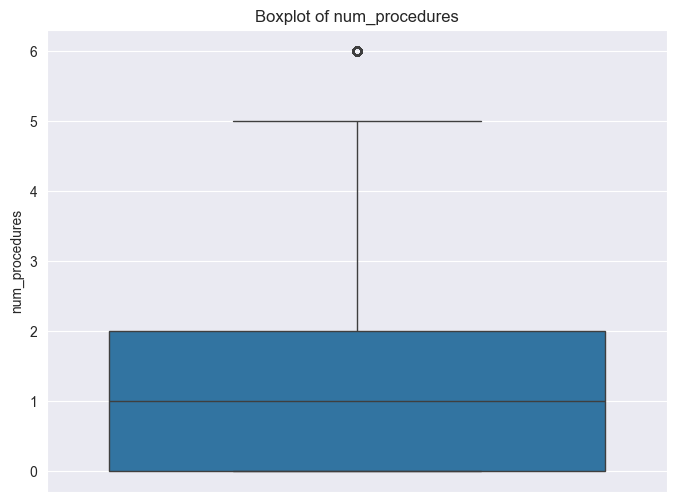

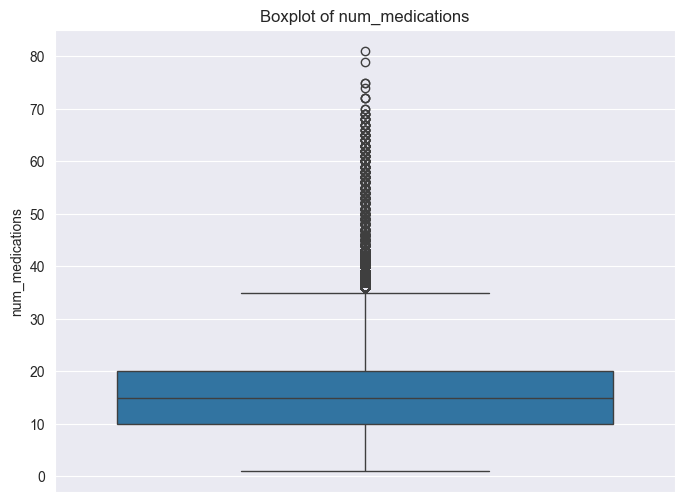

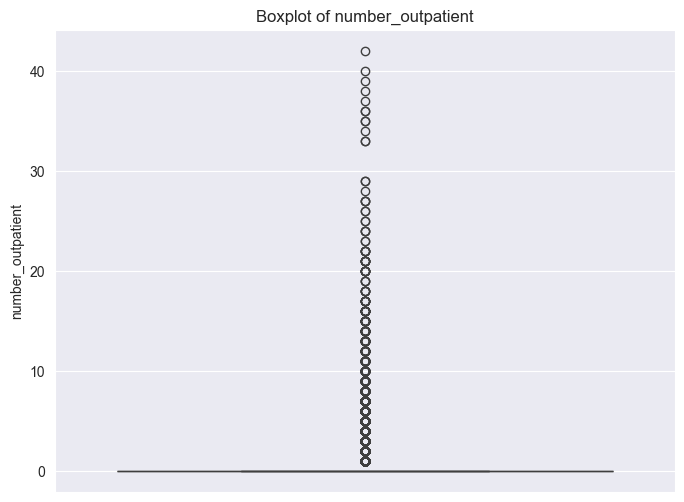

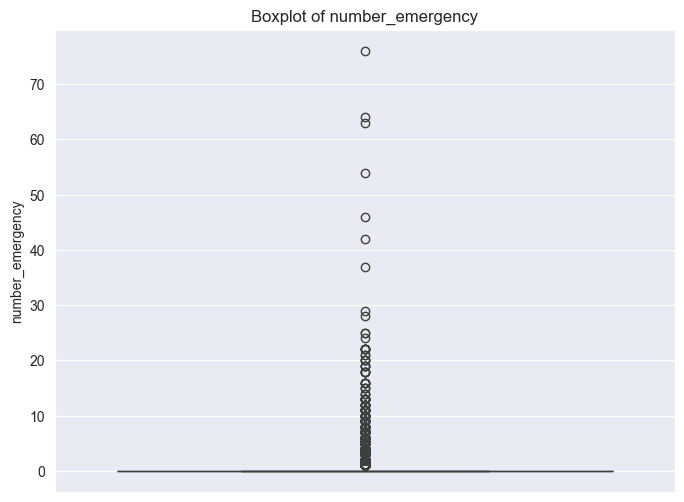

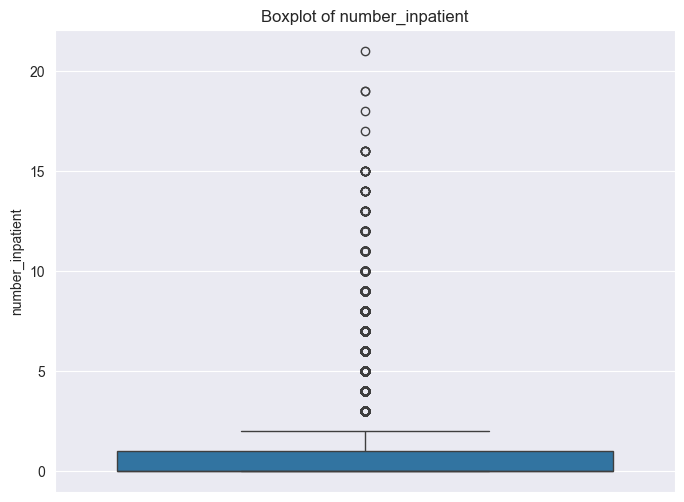

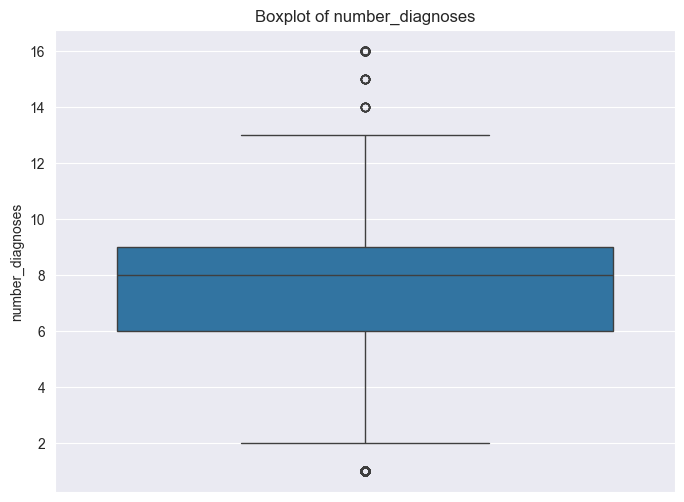

In [14]:
numerical_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
id_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

numerical_cols_for_plotting = [col for col in numerical_cols if col not in id_cols]

print("Boxplots of selected numerical columns (excluding IDs):")
for col in numerical_cols_for_plotting:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

In [15]:

print("Number of outliers (using IQR method):")

for col in numerical_cols_for_plotting:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]

    print(f"Column '{col}': {num_outliers} outliers")

Number of outliers (using IQR method):
Column 'time_in_hospital': 2252 outliers
Column 'num_lab_procedures': 143 outliers
Column 'num_procedures': 4954 outliers
Column 'num_medications': 2557 outliers
Column 'number_outpatient': 16739 outliers
Column 'number_emergency': 11383 outliers
Column 'number_inpatient': 7049 outliers
Column 'number_diagnoses': 281 outliers


In [16]:
df_processed_iqr = df.copy()

columns_to_cap_iqr = ['number_diagnoses', 'num_lab_procedures', 'num_medications', 'num_procedures', 'time_in_hospital']

for col in columns_to_cap_iqr:

    Q1 = df_processed_iqr[col].quantile(0.25)
    Q3 = df_processed_iqr[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_processed_iqr[col] = df_processed_iqr[col].apply(lambda x: lower_bound if x < lower_bound else x)

    df_processed_iqr[col] = df_processed_iqr[col].apply(lambda x: upper_bound if x > upper_bound else x)

print("\nDescriptive Statistics for capped columns after IQR capping:")
display(df_processed_iqr[columns_to_cap_iqr].describe())


Descriptive Statistics for capped columns after IQR capping:


,number_diagnoses,num_lab_procedures,num_medications,num_procedures,time_in_hospital
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,7.422395,43.087210,15.808512,1.291050,4.363618
std,1.925325,19.648915,7.396645,1.581884,2.892181
min,1.500000,1.000000,1.000000,0.000000,1.000000
25%,6.000000,31.000000,10.000000,0.000000,2.000000
50%,8.000000,44.000000,15.000000,1.000000,4.000000
75%,9.000000,57.000000,20.000000,2.000000,6.000000
max,13.500000,96.000000,35.000000,5.000000,12.000000


Boxplots for columns after IQR-based outlier capping:


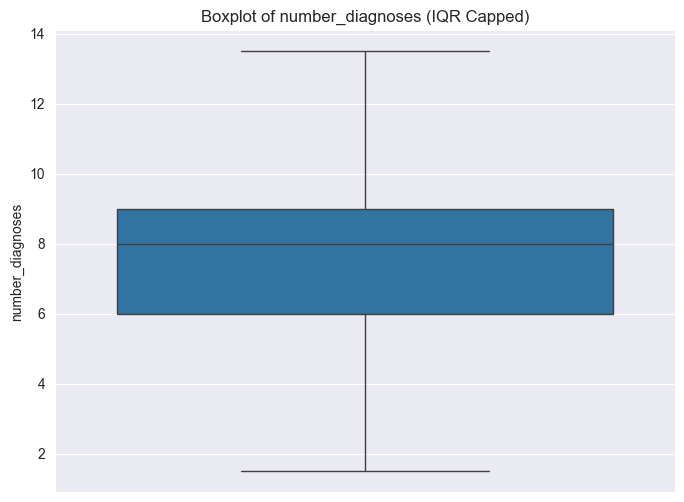

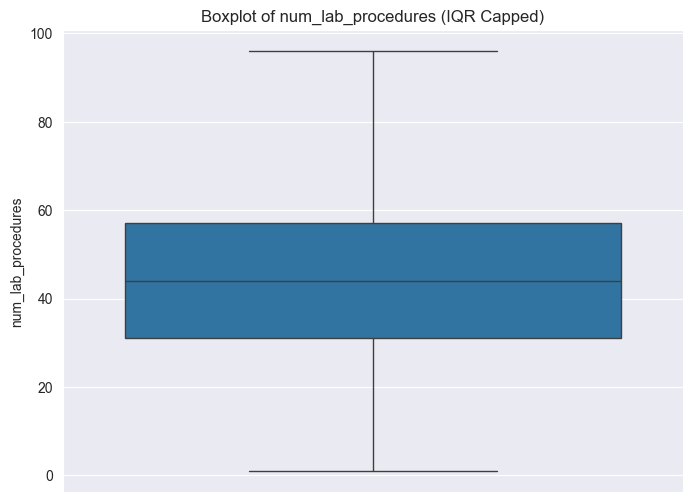

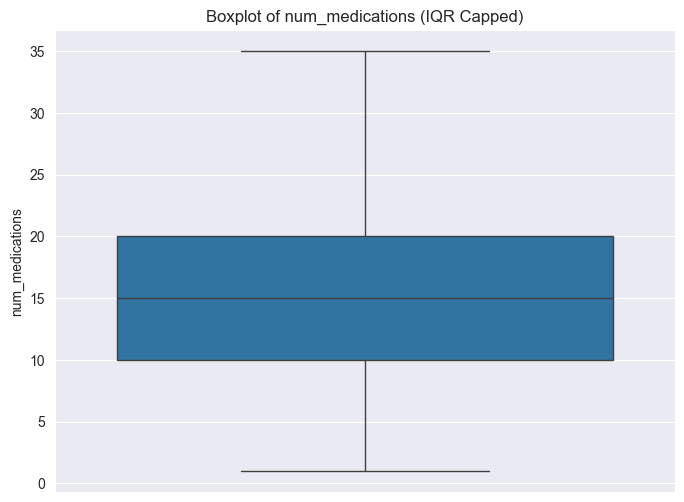

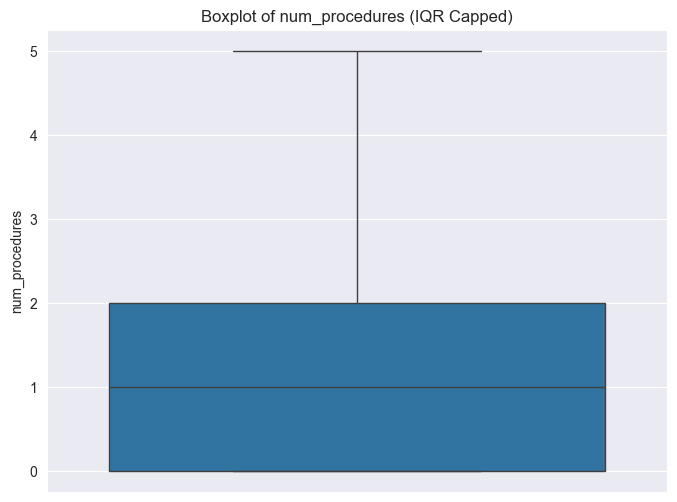

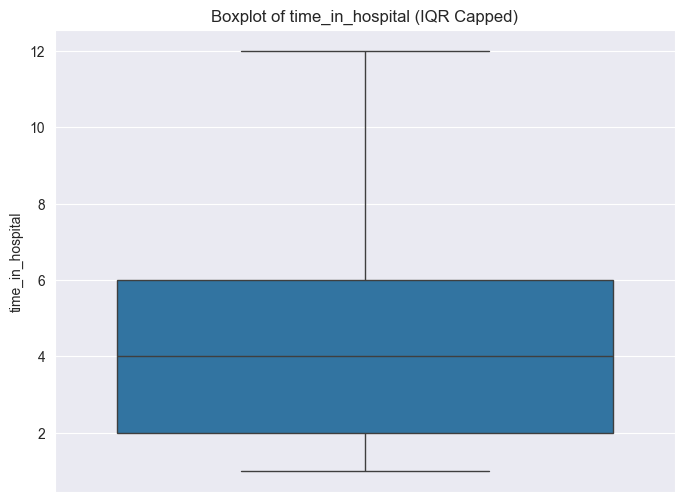

In [17]:

columns_to_plot_iqr_capped = ['number_diagnoses', 'num_lab_procedures', 'num_medications', 'num_procedures', 'time_in_hospital']

print("Boxplots for columns after IQR-based outlier capping:")

for col in columns_to_plot_iqr_capped:

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_processed_iqr, y=col)
    plt.title(f'Boxplot of {col} (IQR Capped)')
    plt.ylabel(col)
    plt.show()


In [18]:
categorical_cols_for_encoding = df.select_dtypes(include=['category']).columns.tolist()

cols_to_keep_all = [col for col in categorical_cols_for_encoding if df[col].nunique() > 2]

cols_to_drop_first = [col for col in categorical_cols_for_encoding if df[col].nunique() == 2]

df_encoded = pd.get_dummies(df, columns=cols_to_drop_first, drop_first=True, prefix_sep='|')

df_encoded = pd.get_dummies(df_encoded, columns=cols_to_keep_all, drop_first=False, prefix_sep='|')



print("Shape of new DataFrame:", df_encoded.shape)
print("\nColumns after one-hot encoding:")
print(df_encoded.columns)

correlation_matrix = df_encoded.corrwith(df_encoded['diabetesMed|Yes'])

encoded_cols = [col for col in df_encoded.columns if df_encoded[col].dtype != 'float']
df_encoded[encoded_cols] = df_encoded[encoded_cols].astype(int)


print("\nCorrelation with 'diabetesMed|Yes':")
display(correlation_matrix.sort_values(ascending=False).head(30))
display(correlation_matrix.sort_values(ascending=True).head(30))

Shape of new DataFrame: (101766, 1158)

Columns after one-hot encoding:
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'diag|820', 'diag|276',
       ...
       'insulin|No', 'insulin|Steady', 'insulin|Up',
       'glyburide.metformin|Down', 'glyburide.metformin|No',
       'glyburide.metformin|Steady', 'glyburide.metformin|Up', 'class|<30',
       'class|>30', 'class|NO'],
      dtype='object', length=1158)

Correlation with 'diabetesMed|Yes':


diabetesMed|Yes                       1.000000
insulin|Steady                        0.360434
metformin|Steady                      0.256281
insulin|Down                          0.201861
glipizide|Steady                      0.193680
insulin|Up                            0.193296
num_medications                       0.186910
glyburide|Steady                      0.173046
pioglitazone|Steady                   0.148253
rosiglitazone|Steady                  0.137996
glimepiride|Steady                    0.119850
A1Cresult|>8                          0.093123
repaglinide|Steady                    0.064168
time_in_hospital                      0.062520
diag|250.02                           0.058306
metformin|Up                          0.056254
glyburide|Up                          0.049011
glipizide|Up                          0.047717
class|>30                             0.046396
glyburide.metformin|Steady            0.045218
payer_code|MC                         0.044897
nateglinide|S

insulin|No                    -0.585464
change|No                     -0.506370
metformin|No                  -0.270176
glipizide|No                  -0.206230
glyburide|No                  -0.186835
pioglitazone|No               -0.152230
rosiglitazone|No              -0.141157
glimepiride|No                -0.126699
payer_code|Missing            -0.075663
discharge_disposition_id|18   -0.069842
A1Cresult|None                -0.069683
repaglinide|No                -0.067718
class|NO                      -0.061508
max_glu_serum|Norm            -0.046610
glyburide.metformin|No        -0.045677
nateglinide|No                -0.045579
diag|560                      -0.041975
discharge_disposition_id|11   -0.033247
diag|562                      -0.032704
diag|789                      -0.031176
admission_type_id|6           -0.030737
payer_code|HM                 -0.030696
acarbose|No                   -0.030110
age|[90-100)                  -0.029543
admission_source_id|5         -0.027727


In [19]:
encoded_columns = df_encoded.columns

feature_counts = {}

for col in encoded_columns:
    parts = col.split('|')

    if len(parts) > 1:
        original_feature = parts[0]

        if original_feature in feature_counts:
            feature_counts[original_feature] += 1
        else:
            feature_counts[original_feature] = 1


print("Number of encoded columns per original feature:")
for feature, count in feature_counts.items():
    print(f"{feature}: {count}")

Number of encoded columns per original feature:
diag: 915
acetohexamide: 1
tolbutamide: 1
troglitazone: 1
glipizide.metformin: 1
glimepiride.pioglitazone: 1
metformin.rosiglitazone: 1
metformin.pioglitazone: 1
change: 1
diabetesMed: 1
admission_type_id: 8
discharge_disposition_id: 26
admission_source_id: 17
race: 5
gender: 3
age: 10
payer_code: 18
medical_specialty: 73
max_glu_serum: 4
A1Cresult: 4
metformin: 4
repaglinide: 4
nateglinide: 4
chlorpropamide: 4
glimepiride: 4
glipizide: 4
glyburide: 4
pioglitazone: 4
rosiglitazone: 4
acarbose: 4
miglitol: 4
tolazamide: 3
insulin: 4
glyburide.metformin: 4
class: 3


In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['diabetesMed|Yes'])
y = df_encoded['diabetesMed|Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)

importances_sorted = importances.sort_values(ascending=False)
print(importances_sorted.head(50))

top_features = importances_sorted.head(200).index
X_selected = X[top_features]

insulin|No                     0.203247
insulin|Steady                 0.118488
change|No                      0.109652
metformin|No                   0.056178
metformin|Steady               0.045816
glipizide|No                   0.040249
glyburide|No                   0.037778
glipizide|Steady               0.035408
glyburide|Steady               0.028158
insulin|Down                   0.022906
insulin|Up                     0.020622
pioglitazone|No                0.017254
pioglitazone|Steady            0.016954
glimepiride|No                 0.015516
num_medications                0.015456
rosiglitazone|No               0.014362
glimepiride|Steady             0.013361
rosiglitazone|Steady           0.013116
num_lab_procedures             0.007958
time_in_hospital               0.006023
number_diagnoses               0.004571
repaglinide|Steady             0.004138
repaglinide|No                 0.004080
num_procedures                 0.003941
number_inpatient               0.003153


In [21]:
correlated_features = correlation_matrix[abs(correlation_matrix) > 0.05].index.tolist()

important_features = importances_sorted[importances_sorted > 0.005].index.tolist()

selected_features = list(set(correlated_features) | set(important_features))

if 'diabetesMed|Yes' in selected_features:
    selected_features.remove('diabetesMed|Yes')

print("Features with absolute correlation > 0.05:")
print(correlated_features)
print(f"\nNumber of selected features: {len(correlated_features)}")
print("\nFeatures with importance > 0.005:")
print(important_features)
print(f"\nNumber of selected features: {len(important_features)}")
print("\nSelected features (meeting both criteria):")
print(selected_features)
print(f"\nNumber of selected features: {len(selected_features)}")

Features with absolute correlation > 0.05:
['time_in_hospital', 'num_medications', 'diag|250.02', 'change|No', 'diabetesMed|Yes', 'discharge_disposition_id|18', 'payer_code|Missing', 'A1Cresult|>8', 'A1Cresult|None', 'metformin|No', 'metformin|Steady', 'metformin|Up', 'repaglinide|No', 'repaglinide|Steady', 'glimepiride|No', 'glimepiride|Steady', 'glipizide|No', 'glipizide|Steady', 'glyburide|No', 'glyburide|Steady', 'pioglitazone|No', 'pioglitazone|Steady', 'rosiglitazone|No', 'rosiglitazone|Steady', 'insulin|Down', 'insulin|No', 'insulin|Steady', 'insulin|Up', 'class|NO']

Number of selected features: 29

Features with importance > 0.005:
['insulin|No', 'insulin|Steady', 'change|No', 'metformin|No', 'metformin|Steady', 'glipizide|No', 'glyburide|No', 'glipizide|Steady', 'glyburide|Steady', 'insulin|Down', 'insulin|Up', 'pioglitazone|No', 'pioglitazone|Steady', 'glimepiride|No', 'num_medications', 'rosiglitazone|No', 'glimepiride|Steady', 'rosiglitazone|Steady', 'num_lab_procedures', 

In [22]:
df_encoded.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag|820,diag|276,...,insulin|No,insulin|Steady,insulin|Up,glyburide.metformin|Down,glyburide.metformin|No,glyburide.metformin|Steady,glyburide.metformin|Up,class|<30,class|>30,class|NO
0,4,41,2,17,0,0,0,9,1,0,...,0,1,0,0,1,0,0,0,0,1
1,3,64,0,10,0,0,1,7,0,1,...,0,1,0,0,1,0,0,0,0,1
2,2,39,0,8,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,1
3,1,39,2,12,0,0,1,3,0,0,...,1,0,0,0,1,0,0,0,0,1
4,3,21,2,23,1,0,0,9,0,0,...,1,0,0,0,1,0,0,0,0,1


In [23]:
X = df_encoded[selected_features]
y = df_encoded['diabetesMed|Yes']



print("Shape before dropping duplicates:", X.shape)
X = X.drop_duplicates()
y = y.loc[X.index]
print("Shape after dropping duplicates:", X.shape)


print("Shape of feature set (X):", X.shape)
print("Shape of target variable (y):", y.shape)

X.head()

Shape before dropping duplicates: (101766, 29)
Shape after dropping duplicates: (92878, 29)
Shape of feature set (X): (92878, 29)
Shape of target variable (y): (92878,)


,glyburide|Steady,A1Cresult|None,metformin|Steady,repaglinide|Steady,insulin|Steady,class|NO,glipizide|Steady,glyburide|No,payer_code|Missing,num_lab_procedures,...,rosiglitazone|No,insulin|No,glimepiride|No,num_medications,change|No,metformin|No,glimepiride|Steady,metformin|Up,time_in_hospital,repaglinide|No
0,0,1,0,0,1,1,1,1,0,41,...,1,0,1,17,0,1,0,0,4,1
1,1,1,0,0,1,1,0,0,0,64,...,1,0,1,10,0,1,0,0,3,1
2,0,1,1,0,1,1,0,1,1,39,...,1,0,1,8,0,0,0,0,2,1
3,0,1,0,0,0,1,0,1,0,39,...,1,1,1,12,1,1,0,0,1,1
4,1,1,1,0,0,1,0,0,0,21,...,1,1,1,23,0,0,0,0,3,1


<br><br><br>

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test  = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test  = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)


print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: torch.Size([74302, 29])
Shape of X_test: torch.Size([18576, 29])
Shape of y_train: torch.Size([74302, 1])
Shape of y_test: torch.Size([18576, 1])


In [25]:
cfg = {
    "n_input": 29,
    "layers": [90, 29, 1],
    "activations": ["ReLU", "ReLU", None],
    "output_activation": None
}


In [26]:
model = MultilayerPerceptron(cfg)

In [27]:
print(model)

MultilayerPerceptron(
  (main): Sequential(
    (0): Linear(in_features=29, out_features=90, bias=True)
    (1): ReLU()
    (2): Linear(in_features=90, out_features=29, bias=True)
    (3): ReLU()
    (4): Linear(in_features=29, out_features=1, bias=True)
  )
)


In [28]:
x = torch.randn(8, 29)  # batch of 8 samples, each with 16 features
y_pred = model(x)
print("Output shape:", y_pred.shape)

Output shape: torch.Size([8, 1])


In [29]:
import torch.nn as nn
import torch.optim as optim

pos = y_train.sum()
neg = len(y_train) - pos
pos_weight = neg / pos
print(pos_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

tensor(0.2514)


In [30]:
for epoch in range(100):
    
    
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.2765
Epoch 2, Loss: 0.2734
Epoch 3, Loss: 0.2737
Epoch 4, Loss: 0.2722
Epoch 5, Loss: 0.2703
Epoch 6, Loss: 0.2693
Epoch 7, Loss: 0.2693
Epoch 8, Loss: 0.2688
Epoch 9, Loss: 0.2678
Epoch 10, Loss: 0.2667
Epoch 11, Loss: 0.2660
Epoch 12, Loss: 0.2657
Epoch 13, Loss: 0.2651
Epoch 14, Loss: 0.2641
Epoch 15, Loss: 0.2632
Epoch 16, Loss: 0.2624
Epoch 17, Loss: 0.2617
Epoch 18, Loss: 0.2608
Epoch 19, Loss: 0.2596
Epoch 20, Loss: 0.2583
Epoch 21, Loss: 0.2572
Epoch 22, Loss: 0.2560
Epoch 23, Loss: 0.2546
Epoch 24, Loss: 0.2532
Epoch 25, Loss: 0.2519
Epoch 26, Loss: 0.2504
Epoch 27, Loss: 0.2487
Epoch 28, Loss: 0.2468
Epoch 29, Loss: 0.2450
Epoch 30, Loss: 0.2431
Epoch 31, Loss: 0.2411
Epoch 32, Loss: 0.2392
Epoch 33, Loss: 0.2373
Epoch 34, Loss: 0.2352
Epoch 35, Loss: 0.2330
Epoch 36, Loss: 0.2308
Epoch 37, Loss: 0.2285
Epoch 38, Loss: 0.2262
Epoch 39, Loss: 0.2238
Epoch 40, Loss: 0.2215
Epoch 41, Loss: 0.2189
Epoch 42, Loss: 0.2163
Epoch 43, Loss: 0.2137
Epoch 44, Loss: 0.21

Test Loss: 0.0447
Accuracy:     0.9325
Precision:    1.0000
Recall/ Sensitivity: 0.9156
Specificity:  1.0000
F1-Score:     0.9559
ROC-AUC:      0.9972


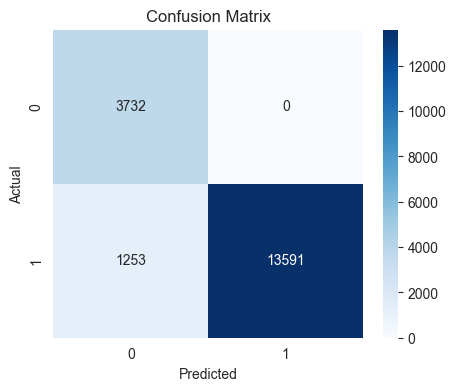

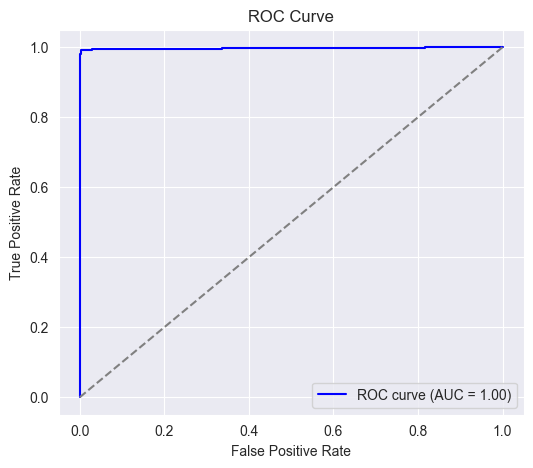

In [31]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)

model.eval()  # set to evaluation mode
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_labels = (y_pred >= 0.5).float()  # convert probabilities to 0/1

loss = criterion(y_pred, y_test)
print(f"Test Loss: {loss.item():.4f}")

y_true = y_test.numpy()
y_pred_np = y_pred_labels.numpy()

accuracy = accuracy_score(y_true, y_pred_np)
precision = precision_score(y_true, y_pred_np)
recall = recall_score(y_true, y_pred_np)  # sensitivity
f1 = f1_score(y_true, y_pred_np)
roc_auc = roc_auc_score(y_true, y_pred.numpy())

# Confusion matrix for specificity
cm = confusion_matrix(y_true, y_pred_np)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # same as recall
specificity = tn / (tn + fp)

print(f"Accuracy:     {accuracy:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall/ Sensitivity: {sensitivity:.4f}")
print(f"Specificity:  {specificity:.4f}")
print(f"F1-Score:     {f1:.4f}")
print(f"ROC-AUC:      {roc_auc:.4f}")

cm = confusion_matrix(y_true, y_pred_np)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_true, y_pred.numpy())
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()